# House Prices - Advanced Regression Techniques 

#### kaggle Leaderboard Score: 0.12907

In [1]:
import pandas as pd
import numpy as np
np.random.seed(11)
from numpy import unique
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr
from datetime import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_selector

from sklearn.base import BaseEstimator, TransformerMixin

from feature_engine.encoding import RareLabelEncoder

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',100)

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [2]:
train = pd.read_csv('train.csv').set_index("Id")
test= pd.read_csv('test.csv').set_index("Id")

In [3]:
test_id = test.index.copy()

## Explonatory Data Analysis

In [4]:
train.shape

(1460, 80)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

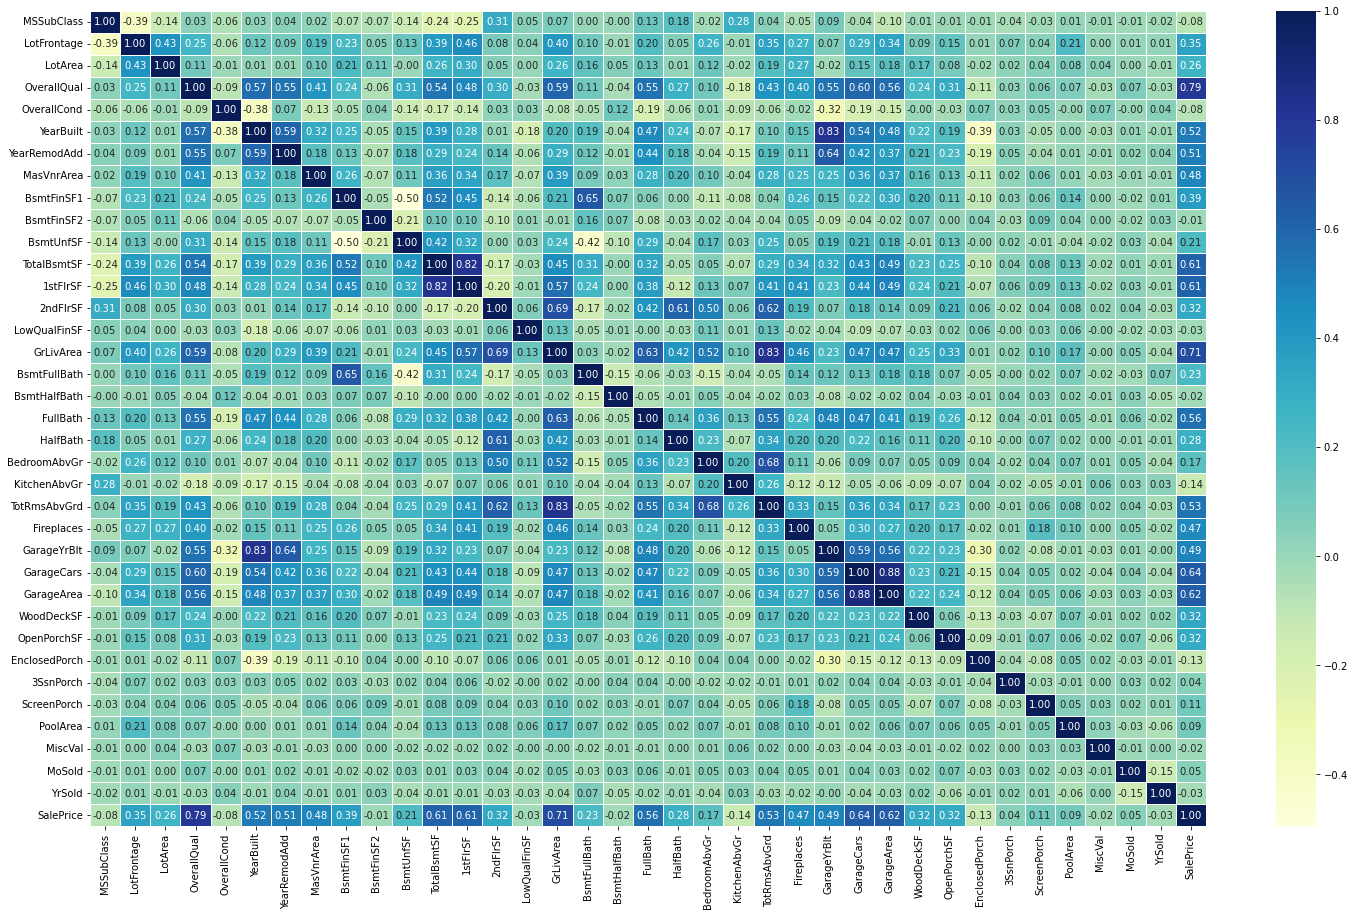

In [6]:
corr_matrix = train.corr()
plt.figure(figsize=(25,15))
sns.heatmap(corr_matrix, annot=True, linewidth=0.5, fmt='.2f',cmap='YlGnBu');

In [7]:
X = train.drop(['SalePrice'], axis=1)
y = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [8]:
X_train.duplicated().any()

False

In [9]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
288,20,RL,NaN,8125,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,4,1971,1971,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,614,Unf,0,244,858,GasA,TA,Y,SBrkr,858,0,0,858,0,0,1,0,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
727,20,RL,NaN,21695,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,9,1988,2007,Hip,CompShg,Wd Sdng,Plywood,BrkFace,260.0,Gd,Gd,CBlock,Gd,TA,No,GLQ,808,Unf,0,72,880,GasA,Ex,Y,SBrkr,1680,0,0,1680,1,0,2,0,3,1,Gd,5,Typ,1,Gd,Attchd,1988.0,Fin,2,540,TA,TA,Y,292,44,0,182,0,0,NaN,NaN,NaN,0,12,2009,WD,Normal
1005,120,RL,43.0,3182,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,16.0,Gd,TA,PConc,Gd,TA,No,GLQ,16,Unf,0,1330,1346,GasA,Ex,Y,SBrkr,1504,0,0,1504,0,0,2,0,1,1,Gd,7,Typ,1,Gd,Attchd,2005.0,Fin,2,457,TA,TA,Y,156,0,0,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal
490,180,RM,21.0,1526,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,SFoyer,4,8,1970,2002,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,Gd,CBlock,Gd,TA,Av,GLQ,515,Unf,0,115,630,GasA,TA,Y,SBrkr,630,0,0,630,1,0,1,0,1,1,Gd,3,Typ,0,NaN,Attchd,1970.0,Unf,1,286,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal
1199,20,RL,70.0,9100,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2001,2001,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1212,1212,GasA,Ex,Y,SBrkr,1212,0,0,1212,0,0,2,0,3,1,Gd,6,Typ,0,NaN,Attchd,2001.0,RFn,2,573,TA,TA,Y,356,0,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal


# Data Preproessing

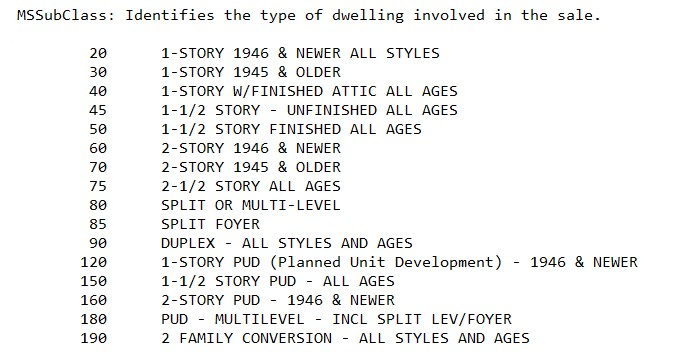

In [10]:
X_train['MSSubClass'].value_counts()

20     427
60     237
50     121
120     68
30      55
160     51
70      50
80      46
90      42
190     22
85      17
75      13
45      10
180      7
40       2
Name: MSSubClass, dtype: int64

`MSSubClass` should be converted into 'object' dtype

In [11]:
X_train['MSSubClass'] = X_train['MSSubClass'].astype(str)

In [12]:
X_train['MSSubClass'].info()

<class 'pandas.core.series.Series'>
Int64Index: 1168 entries, 288 to 1105
Series name: MSSubClass
Non-Null Count  Dtype 
--------------  ----- 
1168 non-null   object
dtypes: object(1)
memory usage: 18.2+ KB


In [13]:
def missing_value_columns(X):
    for i in range(X.shape[1]):
        if X[X.columns[i]].isnull().mean() > 0:
            print(f'{X.columns[i]}: {X[X.columns[i]].isnull().mean():.4f}')

In [14]:
missing_value_columns(X_train)

LotFrontage: 0.1832
Alley: 0.9358
MasVnrType: 0.0043
MasVnrArea: 0.0043
BsmtQual: 0.0257
BsmtCond: 0.0257
BsmtExposure: 0.0265
BsmtFinType1: 0.0257
BsmtFinType2: 0.0265
Electrical: 0.0009
FireplaceQu: 0.4700
GarageType: 0.0574
GarageYrBlt: 0.0574
GarageFinish: 0.0574
GarageQual: 0.0574
GarageCond: 0.0574
PoolQC: 0.9949
Fence: 0.8048
MiscFeature: 0.9615


## Dealing with missing values

**Columns which have meaning for `NA` data**

In [15]:
missing_value_columns(X_train)

LotFrontage: 0.1832
Alley: 0.9358
MasVnrType: 0.0043
MasVnrArea: 0.0043
BsmtQual: 0.0257
BsmtCond: 0.0257
BsmtExposure: 0.0265
BsmtFinType1: 0.0257
BsmtFinType2: 0.0265
Electrical: 0.0009
FireplaceQu: 0.4700
GarageType: 0.0574
GarageYrBlt: 0.0574
GarageFinish: 0.0574
GarageQual: 0.0574
GarageCond: 0.0574
PoolQC: 0.9949
Fence: 0.8048
MiscFeature: 0.9615


In [16]:
na_with_value = ['Alley','BsmtQual','BsmtCond',
                 'BsmtExposure','BsmtFinType1','BsmtFinType2',
                 'FireplaceQu','GarageType','GarageFinish',
                 'GarageQual','GarageCond','PoolQC',
                 'Fence','MiscFeature']

### Impute `None` for columns which `NA` with meaning

In [17]:
for column in na_with_value:
    X_train[column] = X_train[column].fillna('None')

In [18]:
X_train['GarageYrBlt'] = X_train['GarageYrBlt'].fillna(2099)

In [19]:
X_train['MoSold'] = X_train['MoSold'].astype(str)

In [20]:
categorical_features = X_train.select_dtypes(include='object')
categorical_features = list(categorical_features.columns)

numerical_features = X_train.select_dtypes(exclude='object')
numerical_features = list(numerical_features.columns)

In [21]:
preprocessing_missing = ColumnTransformer(transformers=[
    ('num_imputer', SimpleImputer(strategy='median'),numerical_features),
    ('cat_imputer', SimpleImputer(strategy='most_frequent'),categorical_features)
])

In [22]:
preprocessing_missing.fit(X_train)
X_train = preprocessing_missing.transform(X_train)
X_train = pd.DataFrame(X_train, columns=numerical_features+categorical_features)
X_train[numerical_features] = X_train[numerical_features].astype(int)

In [23]:
rare_column = []
for col in X_train.columns:
    if X_train[col].dtypes == 'O':
        if X_train[col].nunique() > 3:
            rare_column.append(col)
            print(X_train.groupby(col)[col].count() / len(X_train))
            print()

MSSubClass
120    0.058219
160    0.043664
180    0.005993
190    0.018836
20     0.365582
30     0.047089
40     0.001712
45     0.008562
50     0.103596
60     0.202911
70     0.042808
75     0.011130
80     0.039384
85     0.014555
90     0.035959
Name: MSSubClass, dtype: float64

MSZoning
C (all)    0.006849
FV         0.048801
RH         0.012842
RL         0.775685
RM         0.155822
Name: MSZoning, dtype: float64

LotShape
IR1    0.334760
IR2    0.029110
IR3    0.008562
Reg    0.627568
Name: LotShape, dtype: float64

LandContour
Bnk    0.046233
HLS    0.035103
Low    0.026541
Lvl    0.892123
Name: LandContour, dtype: float64

LotConfig
Corner     0.178938
CulDSac    0.067637
FR2        0.032534
FR3        0.002568
Inside     0.718322
Name: LotConfig, dtype: float64

Neighborhood
Blmngtn    0.011986
Blueste    0.000856
BrDale     0.010274
BrkSide    0.041096
ClearCr    0.019692
CollgCr    0.105308
Crawfor    0.035103
Edwards    0.065068
Gilbert    0.052226
IDOTRR     0.028253
Me

In [24]:
rare_column.remove('MoSold')

In [25]:
rare_encoder = RareLabelEncoder(tol=0.05, n_categories=3, variables=rare_column)
rare_encoder.fit(X_train.fillna('Missing'))
X_train = rare_encoder.transform(X_train.fillna('Missing'))

In [26]:
X_train['total_square_feet'] = X_train['TotalBsmtSF']+ X_train['1stFlrSF'] + X_train['2ndFlrSF']

X_train['total_bathrooms'] = X_train['FullBath'] + X_train['HalfBath']

X_train['build_to_sell'] = X_train['YrSold'] - X_train['YearRemodAdd']

X_train['quality'] = (X_train['OverallQual']^2) + X_train['OverallCond']

X_train['bath_rooms'] = X_train['FullBath'] + X_train['TotRmsAbvGrd']

In [27]:
X_train.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,SaleType,SaleCondition,total_square_feet,total_bathrooms,build_to_sell,quality,bath_rooms
0,70,8125,4,4,1971,1971,0,614,0,244,858,858,0,0,858,0,0,1,0,3,1,5,0,2099,0,0,0,0,0,0,0,0,0,2006,20,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,None,TA,TA,CBlock,TA,TA,No,BLQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,None,None,None,None,None,Y,None,None,None,6,WD,Normal,1716,1,35,10,6
1,70,21695,6,9,1988,2007,260,808,0,72,880,1680,0,0,1680,1,0,2,0,3,1,5,1,1988,2,540,292,44,0,182,0,0,0,2009,20,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Rare,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Plywood,BrkFace,Gd,Gd,CBlock,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,Fin,TA,TA,Y,None,None,None,12,WD,Normal,2560,2,2,13,7
2,43,3182,7,5,2005,2006,16,16,0,1330,1346,1504,0,0,1504,0,0,2,0,1,1,7,1,2005,2,457,156,0,0,0,0,0,0,2009,120,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Rare,Norm,Norm,TwnhsE,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,Fin,TA,TA,Y,None,None,None,5,WD,Normal,2850,2,3,10,9
3,21,1526,4,8,1970,2002,0,515,0,115,630,630,0,0,630,1,0,1,0,1,1,3,0,1970,1,286,0,0,0,0,0,0,0,2009,Rare,RM,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Rare,Norm,Norm,Rare,Rare,Gable,CompShg,Rare,Rare,None,TA,Gd,CBlock,Gd,TA,Av,GLQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,None,Attchd,Unf,TA,TA,Y,None,None,None,5,WD,Normal,1260,1,7,14,4
4,70,9100,7,5,2001,2001,0,0,0,1212,1212,1212,0,0,1212,0,0,2,0,3,1,6,0,2001,2,573,356,0,0,0,0,0,0,2009,20,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Attchd,RFn,TA,TA,Y,None,None,None,6,WD,Normal,2424,2,8,10,8


In [28]:
scaler_columns = X_train.select_dtypes(exclude='object').columns
scaler_columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'YrSold', 'total_square_feet', 'total_bathrooms', 'build_to_sell',
       'quality', 'bath_rooms'],
      dtype='object')

In [29]:
X_train.shape

(1168, 84)

## Outliers

In [30]:
def diagnostic_plots(df,variable):
    plt.figure(figsize=(16,4))
    
    plt.subplot(1,3,1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')
    
    plt.subplot(1,3,2)
    stats.probplot(df[variable], dist='norm',plot=plt)
    plt.title('Variable Quantiles')
    
    plt.subplot(1,3,3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    
    plt.show()

In [31]:
scaler_columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'YrSold', 'total_square_feet', 'total_bathrooms', 'build_to_sell',
       'quality', 'bath_rooms'],
      dtype='object')

In [32]:
# for i in range(X_train[scaler_columns].shape[1]):
#                    diagnostic_plots(X_train,scaler_columns[i])

In [33]:
outliers = ['LotFrontage','LotArea','MasVnrArea',
            'BsmtFinSF1','TotalBsmtSF','1stFlrSF',
            'GrLivArea']

In [34]:
def find_skewed(df, variable, distance):
    
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    
    lower = df[variable].quantile(0.25) - (IQR * distance)
    upper = df[variable].quantile(0.75) + (IQR * distance)
    
    return upper, lower

In [35]:
upper, lower = find_skewed(X_train,outliers[0], 3)

In [36]:
print(upper)
print(lower)

136.0
3.0


In [37]:
for col in outliers:
    upper, lower = find_skewed(X_train,col, 3)
    X_train[col] = np.where(X_train[col]>upper,upper,np.where(X_train[col]<lower, lower, X_train[col]))

In [38]:
xindex = X_train.index

In [39]:
total_cat_column = X_train.select_dtypes(include='object').columns
ordinal_encode = ['ExterQual','ExterCond','HeatingQC','KitchenQual']
total_cat_column = total_cat_column.drop(['ExterQual','ExterCond','HeatingQC','KitchenQual'])

In [40]:
encoder = OneHotEncoder(categories='auto',sparse=False, handle_unknown='error')
one_hot = encoder.fit_transform(X_train[total_cat_column])
one_hot = pd.DataFrame(one_hot, index=xindex)
one_hot.columns = encoder.get_feature_names_out()

In [41]:
ordinal_encoder = OrdinalEncoder()
ordinal = ordinal_encoder.fit_transform(X_train[ordinal_encode])
ordinal = pd.DataFrame(ordinal, index=xindex)
ordinal.columns = ordinal_encoder.get_feature_names_out()

In [42]:
X_train.drop(total_cat_column, inplace=True, axis=1)
X_train.drop(ordinal_encode, inplace=True, axis=1)

In [43]:
X_train = pd.merge(X_train, one_hot, left_index=True, right_index=True)
X_train = pd.merge(X_train, ordinal, left_index=True, right_index=True)

In [44]:
X_train.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,total_square_feet,total_bathrooms,build_to_sell,quality,bath_rooms,MSSubClass_120,MSSubClass_20,MSSubClass_50,MSSubClass_60,MSSubClass_Rare,MSZoning_RL,MSZoning_RM,MSZoning_Rare,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_Rare,LotShape_Reg,LandContour_Lvl,LandContour_Rare,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,LotConfig_Rare,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_CollgCr,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_NAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Rare,Neighborhood_Sawyer,Neighborhood_Somerst,Condition1_Feedr,Condition1_Norm,Condition1_Rare,Condition2_Norm,Condition2_Rare,BldgType_1Fam,BldgType_Rare,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_Rare,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Rare,RoofMatl_CompShg,RoofMatl_Rare,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Rare,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Rare,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Rare,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Rare,BsmtQual_Ex,BsmtQual_Gd,BsmtQual_Rare,BsmtQual_TA,BsmtCond_Rare,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Rare,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_Rare,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_Rare,BsmtFinType2_Unf,Heating_GasA,Heating_Rare,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_Rare,Electrical_SBrkr,Functional_Rare,Functional_Typ,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Rare,FireplaceQu_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageType_None,GarageType_Rare,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_None,GarageQual_Rare,GarageQual_TA,GarageCond_None,GarageCond_Rare,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_None,PoolQC_Rare,Fence_MnPrv,Fence_None,Fence_Rare,MiscFeature_None,MiscFeature_Rare,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,SaleType_New,SaleType_Rare,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_Rare,ExterQual,ExterCond,HeatingQC,KitchenQual
0,70.0,8125.0,4,4,1971,1971,0.0,614.0,0,244,858.0,858.0,0,0,858.0,0,0,1,0,3,1,5,0,2099,0,0,0,0,0,0,0,0,0,2006,1716,1,35,10,6,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,3.0,3.0
1,70.0,21695.0,6,9,1988,2007,260.0,808.0,0,72,880.0,1680.0,0,0,1680.0,1,0,2,0,3,1,5,1,1988,2,540,292,44,0,182,0,0,0,2009,2560,2,2,13,7,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1

In [45]:
X_train_columns = X_train.columns

In [46]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, index=xindex, columns=X_train_columns)

In [47]:
X_train.shape

(1168, 192)

In [48]:
X_train.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,total_square_feet,total_bathrooms,build_to_sell,quality,bath_rooms,MSSubClass_120,MSSubClass_20,MSSubClass_50,MSSubClass_60,MSSubClass_Rare,MSZoning_RL,MSZoning_RM,MSZoning_Rare,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_Rare,LotShape_Reg,LandContour_Lvl,LandContour_Rare,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,LotConfig_Rare,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_CollgCr,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_NAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Rare,Neighborhood_Sawyer,Neighborhood_Somerst,Condition1_Feedr,Condition1_Norm,Condition1_Rare,Condition2_Norm,Condition2_Rare,BldgType_1Fam,BldgType_Rare,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_Rare,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Rare,RoofMatl_CompShg,RoofMatl_Rare,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Rare,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Rare,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Rare,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Rare,BsmtQual_Ex,BsmtQual_Gd,BsmtQual_Rare,BsmtQual_TA,BsmtCond_Rare,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Rare,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_Rare,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_Rare,BsmtFinType2_Unf,Heating_GasA,Heating_Rare,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_Rare,Electrical_SBrkr,Functional_Rare,Functional_Typ,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Rare,FireplaceQu_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageType_None,GarageType_Rare,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_None,GarageQual_Rare,GarageQual_TA,GarageCond_None,GarageCond_Rare,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_None,PoolQC_Rare,Fence_MnPrv,Fence_None,Fence_Rare,MiscFeature_None,MiscFeature_Rare,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,SaleType_New,SaleType_Rare,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_Rare,ExterQual,ExterCond,HeatingQC,KitchenQual
0,0.006506,-0.417746,-1.533987,-1.417692,-0.010119,-0.666451,-0.617208,0.402709,-0.288027,-0.733393,-0.468937,-0.806659,-0.805302,-0.126368,-1.301788,-0.823934,-0.246796,-1.040717,-0.757514,0.158095,-0.209883,-0.926581,-0.958295,3.078904,-2.335736,-2.181897,-0.750949,-0.695739,-0.374915,-0.120372,-0.270136,-0.071012,-0.117324,-1.374477,-1.037849,-1.194472,0.578203,-0.701375,-1.045845,-0.248633,1.317332,-0.339953,-0.504544,-0.607688,0.537758,-0.429633,-0.271163,-0.071858,0.071858,-0.190735,0.261951,-0.173154,1.409685,-0.197853,-1.298098,0.347737,-0.347737,0.029273,-0.029273,2.142082,-0.269339,-1.596920,-0.190735,0.250568,-0.226506,-0.101885,-0.343079,-0.263813,-0.234742,2.398217,-0.234742,-0.28545,-0.791670,-0.236765,-0.26008,-0.242755,0.404162,-0.304319,0.106092,-0.106092,0.439379,-0.294129,-0.299253,-0.35236,1.017272,-0.662136,-0.320823,0.525835,-0.487122,-0.159565,0.128593,-0.128593,2.382076,-0.412723,-0.281926,-0.382390,-0.753515,-0.405594,2.483072,-0.404162,-0.327275,-0.394071,-0.739608,-0.395519,-0.664812,0.830845,-0.106092,-0.31593,-0.346189,1.161938,-0.892705,-0.156721,-0.302636,-0.866674,-0.230654,1.135868,-0.324059,0.324059,-0.416976,-0.31593,-0.292407,0.724434,-0.16512,-0.

# Feature Selection

### Remove constant features

**convert all numerical features to object to simulate that they are categorical**

In [49]:
X_train_data = X_train.copy()

In [50]:
X_train_data = X_train_data.astype('O')

In [51]:
constant_features = [feature for feature in X_train_data.columns if X_train_data[feature].nunique()==1]
len(constant_features)

0

In [52]:
# X_train.drop(labels=constant_features, axis=1, inplace=True)

### Remove quasi-constant features

In [53]:
quasi_constant_features = []

for feature in X_train_data.columns:
    predominant = X_train_data[feature].value_counts(normalize=True).sort_values(ascending=False).values[0]
    if predominant > 0.99:
        quasi_constant_features.append(feature)
len(quasi_constant_features)

7

In [54]:
quasi_constant_features

['PoolArea',
 'Street_Grvl',
 'Street_Pave',
 'Utilities_AllPub',
 'Utilities_NoSeWa',
 'PoolQC_None',
 'PoolQC_Rare']

In [55]:
X_train.drop(labels=quasi_constant_features, axis=1, inplace=True)

In [56]:
X_train.shape

(1168, 185)

### Remove Duplicated features

In [57]:
X_train_data = X_train.copy()
X_train_data = X_train_data.astype('O')

In [58]:
duplicated_feat = []

for i in range(0, len(X_train_data.columns)):
    if i % 10 == 0: 
        print(i)

    col_1 = X_train_data.columns[i]

    for col_2 in X_train_data.columns[i + 1:]:
        if X_train_data[col_1].equals(X_train_data[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180


6

In [59]:
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)

In [60]:
X_train.shape

(1168, 182)

In [61]:
X_train_data = X_train.copy()
X_train_data = X_train_data.astype('O')

### Correlation

In [62]:
def correlation(df, threshold):
    col_corr = set()
    
    corr_matrix = df.corr()
    
    for i in range(len(corr_matrix.columns)):
        
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [63]:
corr_features = correlation(X_train, 0.9)

print(f'correlated features: {len(set(corr_features))}')

correlated features: 19


In [64]:
set(corr_features)

{'BsmtCond_TA',
 'BsmtFinType2_Unf',
 'CentralAir_Y',
 'Condition2_Rare',
 'Exterior2nd_MetalSd',
 'Exterior2nd_VinylSd',
 'FireplaceQu_None',
 'Functional_Typ',
 'Heating_Rare',
 'HouseStyle_1.5Fin',
 'LandContour_Rare',
 'LandSlope_Mod',
 'LotShape_Reg',
 'MiscFeature_Rare',
 'RoofMatl_Rare',
 'RoofStyle_Hip',
 'SaleCondition_Partial',
 'bath_rooms',
 'build_to_sell'}

In [65]:
# X_train.drop(labels=corr_features, axis=1, inplace=True)

In [66]:
X_train.shape

(1168, 182)

In [67]:
mi = mutual_info_regression(X_train, y_train)
mi

array([1.80815882e-01, 1.54735683e-01, 5.34416214e-01, 1.15112297e-01,
       3.69686038e-01, 2.65528396e-01, 9.36814649e-02, 1.56747750e-01,
       9.84562214e-03, 1.34866914e-01, 3.88961120e-01, 3.32874618e-01,
       2.00803432e-01, 0.00000000e+00, 4.93717294e-01, 2.95542386e-02,
       9.76003640e-05, 2.82714247e-01, 7.50657384e-02, 5.78453462e-02,
       2.16113592e-02, 1.91594759e-01, 1.66922860e-01, 3.14152587e-01,
       3.78593992e-01, 3.62569439e-01, 9.24071844e-02, 1.39355480e-01,
       3.05710391e-02, 1.00750203e-03, 2.00266603e-02, 0.00000000e+00,
       0.00000000e+00, 6.66456794e-01, 2.82205673e-01, 2.75924536e-01,
       3.33470694e-01, 2.91533156e-01, 3.24469824e-03, 0.00000000e+00,
       2.92762125e-02, 1.07490753e-01, 5.16855711e-02, 6.29120305e-02,
       8.88210852e-02, 1.80760346e-02, 9.88178622e-03, 1.08438193e-02,
       1.54701299e-02, 5.88442527e-02, 9.85624635e-03, 7.94528790e-02,
       1.15144763e-02, 2.48564195e-02, 5.31999905e-03, 2.46659295e-02,
      

Text(0, 0.5, 'Mutual Information')

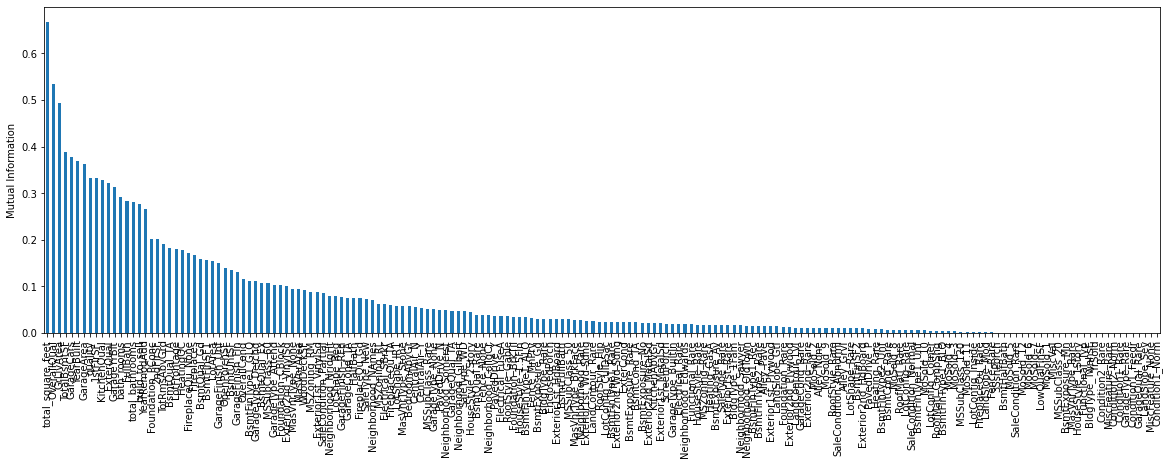

In [68]:
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20,6))
plt.ylabel('Mutual Information')

In [69]:
sel = SelectKBest(mutual_info_regression, k=160).fit(X_train, y_train)

In [70]:
selected_columns = X_train.columns[sel.get_support()]

In [71]:
X_train = X_train[selected_columns]

In [72]:
class PreProcessing(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['MSSubClass'] = X['MSSubClass'].astype(str)
        
        for column in na_with_value:
            X[column] = X[column].fillna('None')
        
        X['GarageYrBlt'] = X['GarageYrBlt'].fillna(2099)
        
        X['MoSold'] = X['MoSold'].astype(str)
        
        X = preprocessing_missing.transform(X)
        X = pd.DataFrame(X, columns=numerical_features+categorical_features)
        X[numerical_features] = X[numerical_features].astype(int)
        
        X = rare_encoder.transform(X.fillna('Missing'))
        
        X['total_square_feet'] = X['TotalBsmtSF']+ X['1stFlrSF'] + X['2ndFlrSF']
        
        X['total_bathrooms'] = X['FullBath'] + X['HalfBath']
        
        X['build_to_sell'] = X['YrSold'] - X['YearRemodAdd']
        
        X['quality'] = (X['OverallQual']^2) + X['OverallCond']
        
        X['bath_rooms'] = X['FullBath'] + X['TotRmsAbvGrd']
        

        
        for col in outliers:
            upper, lower = find_skewed(X,col, 3)
            X[col] = np.where(X[col]>upper,upper,np.where(X[col]<lower, lower, X[col]))

        return X

    
        
class OneHot(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        xindex = X.index
        
        one_hot = encoder.transform(X[total_cat_column])
        one_hot = pd.DataFrame(one_hot, index=xindex)
        one_hot.columns = encoder.get_feature_names_out()
        
        ordinal = ordinal_encoder.transform(X[ordinal_encode])
        ordinal = pd.DataFrame(ordinal, index=xindex)
        ordinal.columns = ordinal_encoder.get_feature_names_out()
        
        X.drop(total_cat_column, inplace=True, axis=1)
        X.drop(ordinal_encode, inplace=True, axis=1)
        
        X = pd.merge(X, one_hot, left_index=True, right_index=True)
        X = pd.merge(X, ordinal, left_index=True, right_index=True)
        
        X = scaler.fit_transform(X)
        X = pd.DataFrame(X, index=xindex, columns=X_train_columns)
        
        return X
    
class FeatureSelection(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.drop(labels=quasi_constant_features, axis=1, inplace=True)
        X.drop(labels=duplicated_feat, axis=1, inplace=True)
        X = X[selected_columns]
        
        return X
        

In [73]:
pipe = Pipeline([
    ('preprocessing', PreProcessing()),
    ('onehot', OneHot()),
    ('feature_selection',FeatureSelection()),
])

## Create a new train data set and apply data preprocessing steps

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [75]:
X_train = pipe.fit_transform(X_train)

## XGBoost Regressor

In [76]:
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror',random_state=11)

In [77]:
scores = cross_val_score(xgb, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
rmse = np.sqrt(-scores)
print(f'RMSE mean: {rmse.mean():.2f}')

RMSE mean: 28323.34


In [78]:
# grid_search(params={'gamma': [0,0.01,0.05,0.1,0.5,1,2,3],
#                     'colsample_bynode':[0.5,0.6,0.7,0.8,0.9,1],
#                     'colsample_bytree':[0.5,0.6,0.7,0.8,0.9,1],
#                     'colsample_bylevel':[0.5,0.6,0.7,0.8,0.9,1],
#                     'subsample':[0.5,0.6,0.7,0.8,0.9,1],
#                     'min_child_weight':[1,2,3,4,5],
#                     'learning_rate':[0.1,0.2,0.3,0.4,0.5],
#                     'max_depth':[1,2,3,4,5,6,7,8,9,None],
#                     'n_estimators': [5,10,15,20,25,50,100,200,400,800]},
#            random=True)

In [79]:
# params={'colsample_bytree':[0.6],
#         'colsample_bylevel':[0.5],
#         'min_child_weight':[1],
#         'learning_rate':[0.1],
#         'max_depth':[2,3,4],
#         'n_estimators': [100,150,200]}

In [80]:
# grid = GridSearchCV(xgb, params, cv=5,scoring='neg_mean_squared_error', n_jobs=-1, return_train_score=False)
# grid.fit(X_train, y_train)
# best_params = grid.best_params_
# print(f"Best params: {best_params}")

In [81]:
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror',
                   n_estimators=300, min_child_weight=1, 
                   max_depth=4,colsample_bytree=0.6,learning_rate=0.1,
                   colsample_bynode=0.9, colsample_bylevel=0.5)

scores = cross_val_score(xgb, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
rmse = np.sqrt(-scores)
print(f'RMSE mean: {rmse.mean():.2f}')

RMSE mean: 25597.03


In [82]:
xgb.fit(X_train, y_train)
X_test = pipe.fit_transform(X_test)
X_test_pred = xgb.predict(X_test)
final_mse = mean_squared_error(y_test,X_test_pred)
final_rmse = np.sqrt(final_mse)
final_rmse

37094.44984235597

In [83]:
prediction_index = range(1,293)

In [84]:
y_test

Id
128      87000
456     175500
1324     82500
218     107000
1182    392500
         ...  
1344    177000
39      109000
852     215000
732     187500
78      127000
Name: SalePrice, Length: 292, dtype: int64

In [85]:
X_test_prediction = pd.Series(X_test_pred, index=prediction_index)
X_test_prediction

1       99160.023438
2      175792.921875
3       84436.632812
4       79786.500000
5      286716.437500
           ...      
288    154336.984375
289    140274.953125
290    211689.265625
291    190701.281250
292    115004.953125
Length: 292, dtype: float32

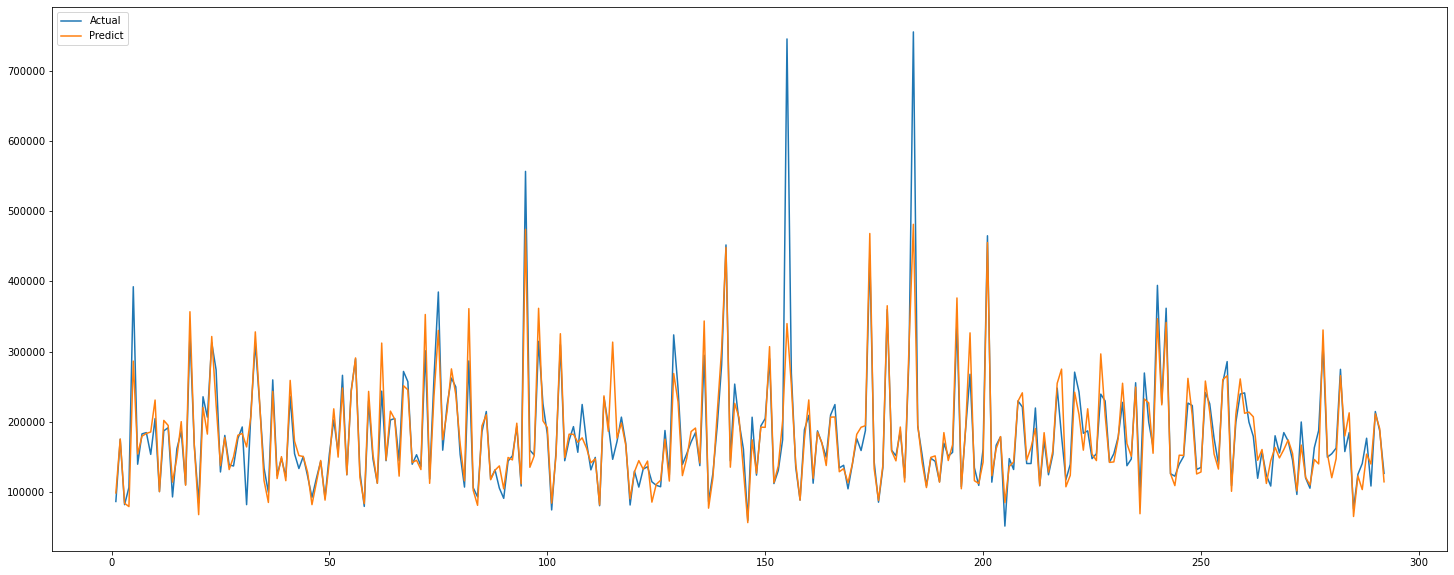

In [86]:
plt.figure(figsize=(25,10))
plt.plot(prediction_index, y_test[0:], label='Actual')
plt.plot(prediction_index, X_test_prediction[0:], label='Predict')
plt.legend(loc='upper left');

In [87]:
test_id = test.index

In [88]:
testing = test.copy()

In [89]:
testing = pipe.transform(testing)

In [90]:
test_pred = xgb.predict(testing)

In [91]:
test_pred = pd.Series(test_pred)

In [92]:
id = pd.Series(test_id)

In [93]:
final = pd.DataFrame({'Id':id.values, 'SalePrice':test_pred.values}).set_index("Id")

In [94]:
final.to_csv('House Price - Regression project.csv')

### kaggle Leaderboard Score: 0.12907